In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [7]:
from google.colab import files
uploaded = files.upload()

Saving ratings.csv to ratings.csv
Saving books.csv to books.csv


In [17]:
books = pd.read_csv("books.csv")
ratings = pd.read_csv("ratings.csv")
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [18]:
books.isnull().sum()

,0
id,0
book_id,0
best_book_id,0
work_id,0
books_count,0
isbn,700
isbn13,585
authors,0
original_publication_year,21
original_title,585


In [16]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [15]:
ratings.isnull().sum()

,0
book_id,0
user_id,0
rating,0


In [33]:
# Merge to add metadata
df = ratings.merge(books, left_on="book_id", right_on="id")

# Create binary label: rating ≥ 4 => finish (1), else drop (0)
df['label'] = (df['rating'] >= 4).astype(int)

# Features
le = LabelEncoder()
df['language_code'] = le.fit_transform(df['language_code'].astype(str))#categorical column

X = df[['average_rating', 'ratings_count', 'work_text_reviews_count', 'language_code']].fillna(0) #numericall columns
y = df['label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [31]:
#Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [27]:
#MLP MODEL
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

model = MLP(input_size=X_train.shape[1])


Epoch 5/20, Loss: 0.6590
Epoch 10/20, Loss: 0.6476
Epoch 15/20, Loss: 0.6389
Epoch 20/20, Loss: 0.6315


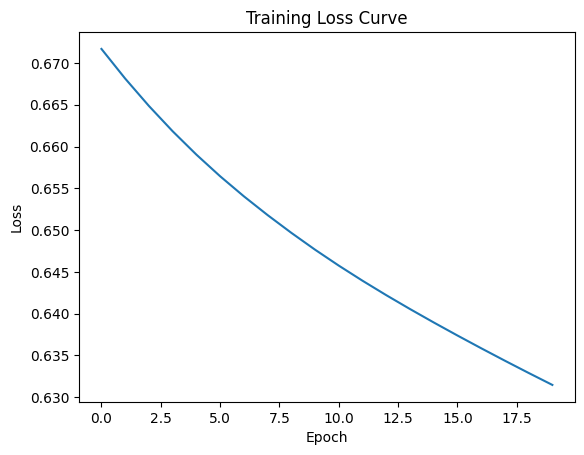

In [28]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
losses = []

for epoch in range(epochs):
    #Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    losses.append(loss.item())

    #Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

#Plot loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


In [29]:
#Evaluation
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_labels = (y_pred_test >= 0.5).int()

acc = accuracy_score(y_test, y_pred_labels)
prec = precision_score(y_test, y_pred_labels)
rec = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.6621
Precision: 0.6620
Recall: 0.9998
F1-score: 0.7966
